This notebook will make 'virtual multi bat' audio files. I use the word 'virtual' here sensu Obrist 1995, Ratcliffe et al. 2004, and Fawcett & Ratcliffe 2015. In the previous experiments the 'virtual' refers to the fact that the authors are comparing the actual difference between acoustic measures when alone vs when they are together, or the difference in call parameters when alone vs in groups. 

Unlike in previous studies which calculated the *difference* in the acoustic measures across single and multi bat contexts, here we will mix the audio data and the generate measures. This raw audio will then be used for analysis. In the end, the observed multi bat audio will be compared to the virtual multi bat audio. If the parameters in the observed and multi bat audio are similar, this is strong evidence that there isn't much of a change in the echolocation behaviour. If there is a difference in the observed multi bat and virtual multi bat, the parameter with the most change is actually informative. 

### Where are the 'single audio' files from 
In a previous notebook ('analysis/Resampling the measurements.ipynb'), I actually ran a comparison of single vs multi bat annotation audio parameters. To perform this analysis I relied on measurements of the annotation audio with 50ms split windows set of valid single and multi annotation audio files ('non_silent_measurements_20dBthreshold.csv'). I will use the single calls in this 'valid set' to generate the virtual multi bat audio.


### How will the virtual audio files be made
I will try and make as many unique pairs and triplets as there are in the observed data. ie. if there are *M* audio files with 2 bats, and *N* audio files with 3 bats, then I will first take $N\times2+M\times3$ single audio files and then create $N+M$ virtual paired and triplet files. 

The WAV files will be loaded and added directly without any further processing. I will use the high-passed audio to reduce the amount of processing I will have to do. I will *not* do any kind of normalisation because the entire point of this exercise is to see if parameters like amplitude will increase or decrease in multi-bat situations. 

Ideally each multi bat audio file will be matched by a virtual multi bat file of the same length. This will help in keeping things the same eg. # of audio segments that will originate from the virtual audio file vs from the observed audio file. 




- Author: Thejasvi Beleyur
- Date: 2020-07-20


### References
- Obrist, M. K. (1995). Flexible bat echolocation: the influence of individual, habitat and conspecifics on sonar signal design. Behavioral ecology and sociobiology, 36(3), 207-219.
- Ratcliffe, J. M., Hofstede, H. M. T., Avila-Flores, R., Fenton, M. B., McCracken, G. F., Biscardi, S., ... & Spanjer, G. (2004). Conspecifics influence call design in the Brazilian free-tailed bat, Tadarida brasiliensis. Canadian Journal of Zoology, 82(6), 966-971.
- Fawcett, K., & Ratcliffe, J. M. (2015). Clutter and conspecifics: a comparison of their influence on echolocation and flight behaviour in Daubenton’s bat, Myotis daubentonii. Journal of Comparative Physiology A, 201(3), 295-304.

In [1]:
%matplotlib notebook

In [2]:
import datetime as dt
import os
import random
random.seed(82320)
import sys
sys.path.append('/home/tbeleyur/Documents/packages_dev/correct_call_annotations/')
sys.path.append('../')
import correct_call_annotations.correct_call_annotations as cca

import soundfile as sf
import tqdm
import numpy as np 
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt 
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
print(f'Notebook run started at {dt.datetime.now()}')

Notebook run started at 2020-09-01 17:29:13.413764


In [4]:
verified_annotations = pd.read_csv('analysis/non_silent_measurements_20dBthreshold.csv')

### Get the total number of single and multi bat annotation files

In [5]:
pairs, triplets  = verified_annotations[verified_annotations['num_bats']==2], verified_annotations[verified_annotations['num_bats']>2]
singles = verified_annotations[verified_annotations['num_bats']==1]


num_pairs = len(np.unique(pairs['video_annot_id']))
num_triplets = len(np.unique(triplets['video_annot_id']))
num_singles = len(np.unique(singles['video_annot_id']))

total_single_calls_needed = num_pairs*2 + num_triplets*3
print(num_singles, num_pairs, num_triplets, total_single_calls_needed)


361 108 15 261


### There are sufficient single annotation audio files to make all required virtual multi bat audio files *uniquely*!
There are right now 361 single audio files, while, we need only a total of 108x2=216 + 15x3=45, or overall 261 files. This is good news in that there will be no need to repeat any files. Moreover, one could also do a series of 'folds' with multiple rounds of virtual multi bat audio files. 

In [6]:
verified_annotations

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
...,...,...,...,...,...,...,...,...
19249,19249,106560.000000,6,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,6_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_90,1
19250,19250,0.015034,3,rms,matching_annotaudio_Aditya_2018-08-20_0300-040...,3_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_91,1
19251,19251,0.044647,3,peak_amplitude,matching_annotaudio_Aditya_2018-08-20_0300-040...,3_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_91,1
19252,19252,86060.000000,3,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-20_0300-040...,3_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_91,1


### How long are the observed multi bat audio files ?
The duration of the multi bat audio files are important because the duration decides how many audio segments can maximally be part of the analysed dataset. Of course, the actual number of segments that are above the threshold will decrease this. It still helps to reduce the disparity between the virtual and observed multi bat audio files.

In [7]:
pairs

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
5,5,0.098816,3,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
6,6,93960.000000,3,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
7,7,102520.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
8,8,102920.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
...,...,...,...,...,...,...,...,...
19122,19122,106000.000000,9,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,9_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_18,2
19123,19123,0.015876,12,rms,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2
19124,19124,0.050446,12,peak_amplitude,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2
19125,19125,99840.000000,12,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2


In [8]:
multi_bat = np.unique(np.concatenate([pairs['file_name'], triplets['file_name']]))
audio_folder = '../individual_call_analysis/hp_annotation_audio/'
file_durations = []
for file_name in tqdm.tqdm(multi_bat):        
    file_path = cca.find_file_in_folder(file_name, audio_folder)
    file_durations.append(sf.info(file_path[0]).duration)
    

  0%|          | 0/123 [00:00<?, ?it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 22%|██▏       | 27/123 [00:00<00:00, 130.01it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 47%|████▋     | 58/123 [00:00<00:00, 140.10it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 76%|███████▌  | 93/123 [00:00<00:00, 153.21it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


100%|██████████| 123/123 [00:00<00:00, 158.32it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


In [9]:
pairs

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
5,5,0.098816,3,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
6,6,93960.000000,3,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
7,7,102520.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
8,8,102920.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
...,...,...,...,...,...,...,...,...
19122,19122,106000.000000,9,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,9_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_18,2
19123,19123,0.015876,12,rms,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2
19124,19124,0.050446,12,peak_amplitude,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2
19125,19125,99840.000000,12,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-20_0300-040...,12_matching_annotaudio_Aditya_2018-08-20_0300-...,Aditya_2018-08-20_0300-0400_18,2


<IPython.core.display.Javascript object>


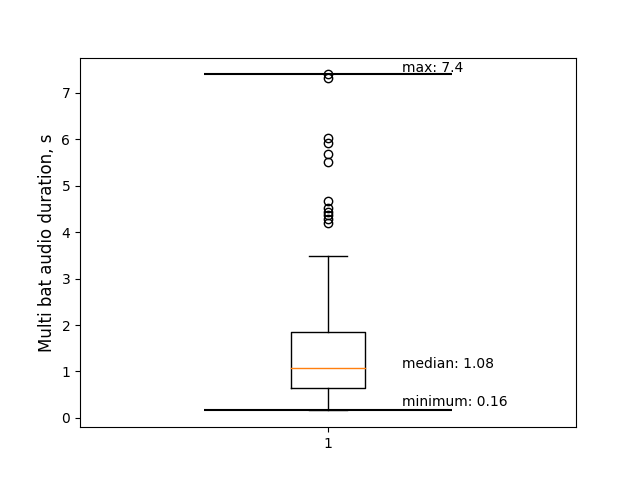

Text(1.15, [0.26], 'minimum: 0.16')

In [10]:
plt.figure()
plt.boxplot(file_durations);
plt.ylabel('Multi bat audio duration, s', fontsize=12)
plt.hlines(np.percentile(file_durations, [0,100]), 0.75, 1.25)
plt.text( 1.15, np.percentile(file_durations, [50]),f'median: {np.percentile(file_durations, 50)}',)
plt.text( 1.15, np.percentile(file_durations, [99.5])+0.1,f'max: {np.percentile(file_durations, 100)}',)
plt.text( 1.15, np.percentile(file_durations, [0])+0.1,f'minimum: {np.percentile(file_durations, 0)}',)

So now, let's only choose audio files which are at least 0.16 to 7.4 seconds long. There is some more thought to be put into how to make virtual multi bat audio files. There may be situations, especially when adding a long-ish file with a short-ish file, where the addition of the two files doesn't really change anything because the calls in one file and the other don't overlap as the active call regions don't overlap. To prevent such cases, it is important to create virtual files that are *matched* with each other in duration, and more importantly, matched with an observed multi bat file in duration. The following set of steps will be followed while creating a virtual multi bat file:

1. Choose one multi bat audio file and get its duration, $multibat_{duration}$
2. Search for all single bat audio files with a duration that is 90-110% of $multibat_{duration}$ 
3. Choose $N$ files from this pool of audio files (where $N$ is either 2 (pair) or 3(triplet))

    a. Check to see if the chosen files have already been used to make a virtual multi bat file (see Step 4)
    
    b. If they have go to step 3 and choose again
    
    c. If after 100,000 tries the same files are coming up, then skip finding a matching audio file for this particular multi bat file.

4. Store the names of the single bat audio files used to make virtual multi bat files. 

5. Add the waveforms of the chosen $N$ files to create a virtual audio file. 


In [11]:
def make_virtual_multi_bat_audio(multi_bat_data, single_bat_files, max_tries = 100*10**3,
                                **kwargs):
    '''
    Parameters
    ----------
    multi_bat_data: pd.DataFrame
        DataFrame with names of the multi bat audio files,
        the number of bats that the corresponding annotation 
        had, and the duration of the audio file. The compulsory
        columns are: 'file_name', 'num_bats', 'duration'
    single_bat_data:
        The names of files with single bat audio in them. The 
        compulsory columns are: 'file_name' and 'duration'
    max_tries : int, optional
        The maximum number of random samplings to try before giving up and moving onto the 
        next multi bat audio file. In the ideal case each virtual multi bat audio needs
        to be from a unique single bat audio file within the acceptable duration range, 
        *And* that hasn't been chosen before. Defaults to 100,000 trials.
    duration_width : 0<float <1, optional 
        When files are chosen that are of similar length to a multi bat file, they need to be within 
        1 +/- duration_width of the multi bat file's duration. 

    Returns
    -------
    matched_files: dictionary
        Keys contain the multi bat audio file name and the items contain 
        the duration matched single bat audio files in a list. 
    '''
    already_chosen = np.array([])
    duration_width = kwargs.get('duration_width', 0.1)
    matched_files = {}
    
    for i, row in multi_bat_data.iterrows():
        filename, numbats, multibat_duration = row
        valid_rows = np.logical_and(single_bat_files['duration']<(1+duration_width)*multibat_duration,
                                   single_bat_files['duration']>(1-duration_width)*multibat_duration)
        valid_data = single_bat_files[valid_rows]
        #print(valid_data)
        unique_files_not_found = True
        tries = 0
        while np.logical_and(unique_files_not_found, tries<max_tries):
            chosen_files = random.choices(valid_data['file_name'].to_list(), k=numbats)
            chosen = set(chosen_files)
            overlap = len(chosen.intersection(set(already_chosen)))
            if overlap <1:
                unique_files_not_found = False
                matched_files[filename] = chosen_files
                already_chosen = list(flatten([chosen_files, already_chosen]))
                tries = 0
            else:
                tries += 1
            if tries>=max_tries:
                print(f'Unable to find correct matches for {filename}')
    
    return matched_files

In [12]:
from random import sample

In [13]:
multi_bat = pd.concat([pairs, triplets]).reset_index(drop=True)

In [14]:
multi_bat

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats
0,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
1,5,0.098816,3,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
2,6,93960.000000,3,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
3,7,102520.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
4,8,102920.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2
...,...,...,...,...,...,...,...,...
5744,19031,104600.000000,44,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,44_matching_annotaudio_Aditya_2018-08-20_0200-...,Aditya_2018-08-20_0200-0300_66,3
5745,19032,0.034413,52,rms,matching_annotaudio_Aditya_2018-08-20_0200-030...,52_matching_annotaudio_Aditya_2018-08-20_0200-...,Aditya_2018-08-20_0200-0300_66,3
5746,19033,0.098938,52,peak_amplitude,matching_annotaudio_Aditya_2018-08-20_0200-030...,52_matching_annotaudio_Aditya_2018-08-20_0200-...,Aditya_2018-08-20_0200-0300_66,3
5747,19034,100480.000000,52,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-20_0200-030...,52_matching_annotaudio_Aditya_2018-08-20_0200-...,Aditya_2018-08-20_0200-0300_66,3


In [15]:
audio_folder = '../individual_call_analysis/hp_annotation_audio/'

def make_fileinfo_dataframe(df, audio_folder):
    '''
    
    '''

    file_durations = []
    num_bats = []
    all_file_names = []
    for file_name in tqdm.tqdm(np.unique(df['file_name'])):        

        file_path = cca.find_file_in_folder(file_name, audio_folder)
        file_durations.append(sf.info(file_path[0]).duration)

        one_annot = df[df['file_name']==file_name]
        num_bats.append(int(np.unique(one_annot['num_bats'])))

        all_file_names.append(file_name)

    df_fileinfo = pd.DataFrame(data={'file_name':all_file_names,
                                           'num_bats':num_bats,
                                           'duration':file_durations})
    return df_fileinfo

In [16]:
multibat_fileinfo = make_fileinfo_dataframe(multi_bat, audio_folder)
singlebat_fileinfo = make_fileinfo_dataframe(singles, audio_folder)

 18%|█▊        | 22/123 [00:00<00:00, 109.03it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 27%|██▋       | 33/123 [00:00<00:00, 107.73it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 52%|█████▏    | 64/123 [00:00<00:00, 102.53it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 72%|███████▏  | 89/123 [00:00<00:00, 111.45it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 83%|████████▎ | 102/123 [00:00<00:00, 115.45it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


  0%|          | 0/361 [00:00<?, ?it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


  7%|▋         | 24/361 [00:00<00:03, 108.88it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 14%|█▍        | 52/361 [00:00<00:02, 122.58it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 27%|██▋       | 97/361 [00:00<00:01, 135.17it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 31%|███       | 111/361 [00:00<00:01, 134.68it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 43%|████▎     | 157/361 [00:01<00:01, 143.72it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 48%|████▊     | 172/361 [00:01<00:01, 142.90it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 56%|█████▌    | 203/361 [00:01<00:01, 139.89it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 65%|██████▌   | 235/361 [00:01<00:00, 140.68it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 73%|███████▎  | 265/361 [00:01<00:00, 139.70it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 82%|████████▏ | 296/361 [00:02<00:00, 143.02it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


 91%|█████████ | 329/361 [00:02<00:00, 152.74it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


100%|██████████| 361/361 [00:02<00:00, 143.04it/s]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


In [17]:
multibat_matched = make_virtual_multi_bat_audio(multibat_fileinfo, singlebat_fileinfo, duration_width=0.2)
len(multibat_matched)

Unable to find correct matches for matching_annotaudio_Aditya_2018-08-19_23_40_hp.WAV
Unable to find correct matches for matching_annotaudio_Aditya_2018-08-20_0200-0300_23_hp.WAV


121

In [22]:
multibat_matched

{'matching_annotaudio_Aditya_2018-08-16_21502300_100_hp.WAV': ['matching_annotaudio_Aditya_2018-08-17_45_113_hp.WAV',
  'matching_annotaudio_Aditya_2018-08-19_0120-0200_112_hp.WAV'],
 'matching_annotaudio_Aditya_2018-08-16_21502300_12_hp.WAV': ['matching_annotaudio_Aditya_2018-08-16_2324_24_hp.WAV',
  'matching_annotaudio_Aditya_2018-08-16_2324_156_hp.WAV'],
 'matching_annotaudio_Aditya_2018-08-16_21502300_18_hp.WAV': ['matching_annotaudio_Aditya_2018-08-16_2324_277_hp.WAV',
  'matching_annotaudio_Aditya_2018-08-17_01_11_hp.WAV'],
 'matching_annotaudio_Aditya_2018-08-16_21502300_20_hp.WAV': ['matching_annotaudio_Aditya_2018-08-16_2324_85_hp.WAV',
  'matching_annotaudio_Aditya_2018-08-16_21502300_111_hp.WAV'],
 'matching_annotaudio_Aditya_2018-08-16_21502300_22_hp.WAV': ['matching_annotaudio_Aditya_2018-08-17_23_137_hp.WAV',
  'matching_annotaudio_Aditya_2018-08-16_21502300_70_hp.WAV'],
 'matching_annotaudio_Aditya_2018-08-16_21502300_26_hp.WAV': ['matching_annotaudio_Aditya_2018-08-17_

In [18]:
virtual_audio_folder = 'virtual_multi_bat_audio/'
if not os.path.isdir(virtual_audio_folder):
    os.mkdir(virtual_audio_folder)

for multibatfile, matched_files in multibat_matched.items():
    # load the 1st channel of all the audio files
    audio_data = []
    for each in matched_files:
        filepath = cca.find_file_in_folder(each, audio_folder)[0]
        audio, fs = sf.read(filepath)
        audio_data.append(audio[:,0])
    smallest_audio = np.min([each.size for each in audio_data])
    combined_audio = np.zeros(smallest_audio)
    
    for singleaudio in audio_data:
        combined_audio += singleaudio[:smallest_audio]
    final_path = os.path.join(virtual_audio_folder,multibatfile[:-4]+'_singlebatmixed.WAV')
    sf.write(final_path, combined_audio, fs)
        

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!

### Also save the source file information for all the virtual multi bat audio files


In [19]:
obs_multibat_files = list(multibat_matched.keys())
source_single_files = [ str(each[1])[2:-2] for each in list(multibat_matched.items())]

virtual_multibat_fileaddition = pd.DataFrame(data={'multibat_filename': obs_multibat_files,
                                                  'source_single_bat_files': source_single_files})
virtual_multibat_fileaddition.to_csv('source_files_for_virtual_multibat_audio.csv')

<IPython.core.display.Javascript object>


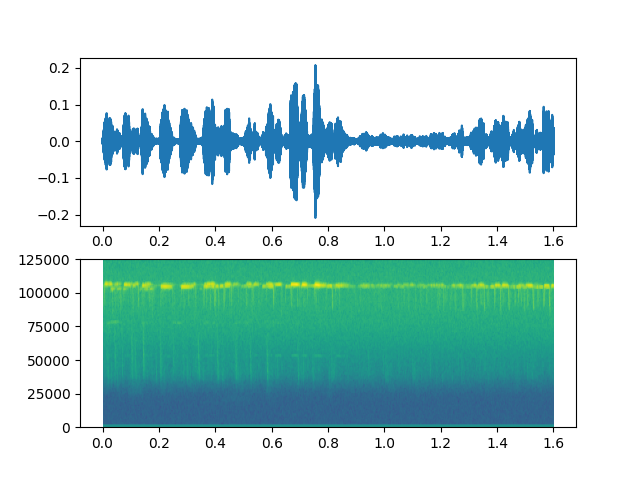

In [20]:
plt.figure()
ax1 = plt.subplot(211)
plt.plot(np.linspace(0,combined_audio.size/fs, combined_audio.size),combined_audio)
ax2 = plt.subplot(212, sharex=ax1)
plt.specgram(combined_audio, Fs=fs);


In [21]:
print(f'Notebook run ended at {dt.datetime.now()}')

Notebook run ended at 2020-09-01 17:29:30.604715
